#**PROJECT - (5th Mar, 2021 - 21st Mar, 2021)**

# **I]. PART ONE**



In [ ]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.4.1'

In [ ]:
project_path  = '/content/drive/MyDrive/My Files/AIML Workbooks/Part 1/'

In [ ]:
import os                   # Importing os library
import pandas as pd         # To read the data set
import numpy as np          # Importing numpy library
import seaborn as sns       # For data visualization
import matplotlib.pyplot as plt      # Necessary library for plotting graphs
from glob import glob       # Importing necessary library
%matplotlib inline
sns.set(color_codes = True)

from sklearn import metrics          # Importing metrics
from sklearn.model_selection import train_test_split       # Splitting data into train and test set
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, roc_auc_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler           # Importing to standardize the data
from sklearn.impute import SimpleImputer                   # Importing to fill in zero values in the data
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import PolynomialFeatures       # Importing polynomial features library
from sklearn.decomposition import PCA           # Importing to run pca analysis on data
from sklearn import svm              # Importing necessary library for model building
from sklearn.ensemble import RandomForestClassifier        # Importing necessary library for model building
from sklearn.neighbors import KNeighborsClassifier         # Importing necessary library for model building  
from sklearn import preprocessing               # Importing preprocessing library 

from sklearn.model_selection import KFold, cross_val_score           # Importing kfold for cross validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV           # Importing for hypertuning model
from sklearn.cluster import KMeans              # For KMeans cluster model building
from scipy.stats import zscore       # Import zscore library
from scipy.spatial.distance import cdist        # Importing cdist functionality for elbow graph
import tensorflow           # Importing tensorflow library
from tensorflow.keras.models import Sequential, Model               # Importing tensorflow library
from tensorflow.keras.utils import to_categorical          # Importing tensorflow library
from tensorflow.keras import optimizers                    # Importing optimizers
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, MaxPooling2D, Conv2D, Flatten, ZeroPadding2D, UpSampling2D, Reshape, SpatialDropout2D, Concatenate      # Importing necessary libraries 
from tensorflow.keras.applications.mobilenet import preprocess_input           # Importing for model building
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau            # Importing for model building 
from tensorflow.keras.applications.mobilenet import MobileNet       # Importing for model building 
from tensorflow.keras.losses import binary_crossentropy             # Importing for model building
from tensorflow.keras.backend import log, epsilon          # Importing necessary library for model building 
from keras.utils import np_utils     # Importing necessary library
from sklearn import svm              # Importing necessary library for model building
from sklearn.svm import SVC          # Import svc library for model building

from skimage.color import rgb2gray              # Loading color library
from sklearn.preprocessing import OneHotEncoder            # Library for one hot encoding
from sklearn.metrics import confusion_matrix               # Loading necessary library
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array            # Loading image generator 
from keras.preprocessing import image           # Importing necessary image library
from tensorflow import keras         # Loading keras libaray 
from tensorflow.keras.optimizers import Adam, SGD          # Importing optimizer library
import cv2                  # Importing necessary library
from PIL import ImageFile            # Importing image library
from tqdm import tqdm                # Importing necessary library
import time                 # Importing time library
from mpl_toolkits.axes_grid1 import ImageGrid              # Importing necessary image library
from PIL import Image       # Importing image library
import tensorflow as tf     # Importing library

## **1. Import the dataset.**

In [ ]:
# Path of the dataset

data = "Part 1- Train data - images.npy"

In [ ]:
# Loading the file 

df = np.load(project_path + data, allow_pickle = True)

In [ ]:
df.shape    # Shape of dataset

(409, 2)

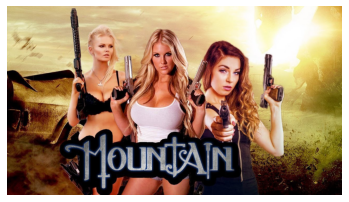

In [ ]:
# Visualizing image from the dataset

plt.axis('off')
plt.imshow(df[100][0])
plt.show()

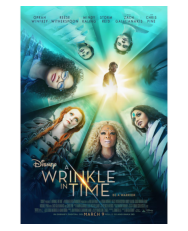

In [ ]:
plt.axis ('off')
plt.imshow(df[125][0])
plt.show()

In [ ]:
# Setting dimensions of the image

image_height = 224
image_width = 224

num_img = int(df.shape[0])
print('Number of images in dataset:', num_img)

Number of images in dataset: 409


## **2. Create features (images) and labels (mask) using that data.**

In [ ]:
masks = np.zeros((num_img, image_height, image_width))
X = np.zeros((num_img, image_height, image_width, 3))
for index in range(num_img):
    image = df[index][0]
    image= cv2.resize(image, dsize = (image_height, image_width))
    try:
      image = image[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(image, dtype = np.float32))
    for i in df[index][1]:
        x1 = int(i['points'][0]['x'] * image_width)
        x2 = int(i['points'][1]['x'] * image_width)
        y1 = int(i['points'][0]['y'] * image_height)
        y2 = int(i['points'][1]['y'] * image_height)
        masks[index][y1:y2, x1:x2] = 1

In [ ]:
print('Shape of image features :', X.shape)      # Image feature shape
print('Shape of image masks :', masks.shape)     # Image masks shape

Shape of image features : (409, 224, 224, 3)
Shape of image masks : (409, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


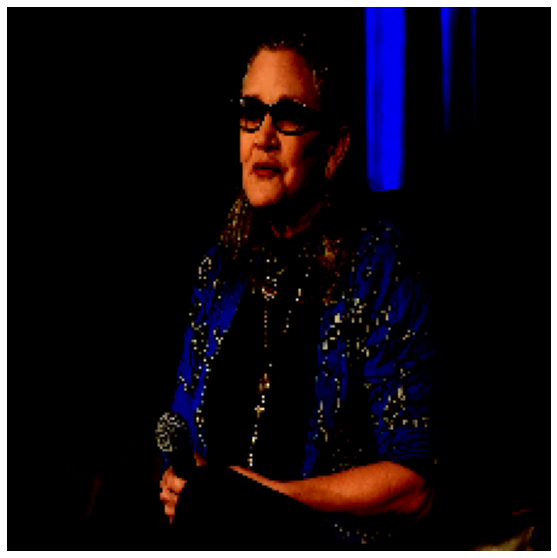

In [ ]:
# Visualizing image and its mask 

Img = plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(X[130])
plt.show()

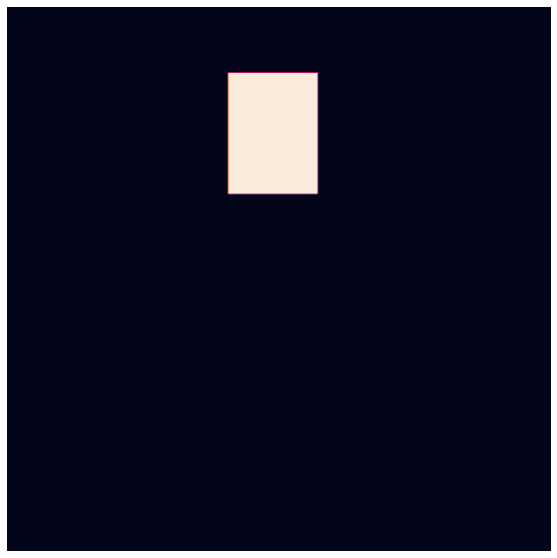

In [ ]:
# Visualizing image and its mask 

Img = plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(masks[130])
plt.show()

## **3. Mask detection model**

In [ ]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable = True):
    model = MobileNet(input_shape = (image_height, image_width, 3), include_top = False, alpha = 1, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable
    
    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output
    
    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 512, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 512, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 128, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 64, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 64, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 32, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 32, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 16, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.1)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((image_height, image_width))(x)
    return Model(inputs = model.input, outputs = x)

In [ ]:
model = create_model(True)
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
_____________________________

In [ ]:
# Designing Dice Coefficient 

def dice_coefficient (y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return numerator / (denominator + tf.keras.backend.epsilon())

In [ ]:
def loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [ ]:
# Building model 

adam = Adam(lr = 1e-7, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = loss, optimizer = adam, metrics = [dice_coefficient])

In [ ]:
checkpoint = ModelCheckpoint('model_{loss:.2f}.h5', monitor = 'loss', verbose = 1, save_best_only = True, save_weights_only = True, mode = 'min', period = 1)
earlystop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')
learn_red = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 1e-9, verbose = 1, mode = 'min')


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, masks, test_size = 0.20, random_state = 42, shuffle = False)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(327, 224, 224, 3)
(82, 224, 224, 3)
(327, 224, 224)
(82, 224, 224)


In [ ]:
# Fitting the model

model.fit(X_train, y_train, epochs = 10, verbose = 1, batch_size = 32, callbacks = [checkpoint, earlystop, learn_red], validation_data = (X_val, y_val))

Epoch 1/10
11/11 [==============================] - 458s 41s/step - loss: 2.3134 - dice_coefficient: 0.2124 - val_loss: 2.2490 - val_dice_coefficient: 0.1698

Epoch 00001: loss improved from inf to 2.35713, saving model to model_2.36.h5
Epoch 2/10
11/11 [==============================] - 448s 41s/step - loss: 2.3322 - dice_coefficient: 0.2096 - val_loss: 2.2245 - val_dice_coefficient: 0.1797

Epoch 00002: loss did not improve from 2.35713
Epoch 3/10
11/11 [==============================] - 452s 41s/step - loss: 2.3489 - dice_coefficient: 0.2064 - val_loss: 2.2202 - val_dice_coefficient: 0.1873

Epoch 00003: loss did not improve from 2.35713
Epoch 4/10
11/11 [==============================] - 456s 41s/step - loss: 2.3103 - dice_coefficient: 0.2114 - val_loss: 2.2277 - val_dice_coefficient: 0.1930

Epoch 00004: loss improved from 2.35713 to 2.34221, saving model to model_2.34.h5
Epoch 5/10
11/11 [==============================] - 459s 42s/step - loss: 2.3337 - dice_coefficient: 0.2068 - 

In [ ]:
model.evaluate(X_val, y_val)

3/3 [==============================] - 25s 8s/step - loss: 2.2894 - dice_coefficient: 0.2079


[2.2893853187561035, 0.20786602795124054]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of image:  (224, 224, 3)


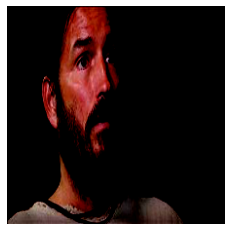

In [ ]:
# Sample image 

n = 75
sample_img = X_train[n]
final_img = sample_img
print('Shape of image: ', sample_img.shape)
plt.axis("off")
plt.imshow(sample_img)
plt.show()

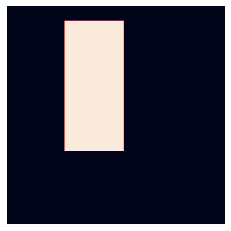

In [ ]:
sample_mask = masks[n]
final_mask = sample_mask
plt.axis("off")
plt.imshow(sample_mask)
plt.show()

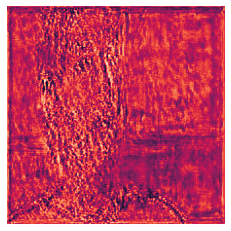

In [ ]:
sample_img = np.resize(sample_img, (1, image_height, image_width, 3))
pd_mask = model.predict(x = sample_img)
pd_mask = np.resize(pd_mask, (image_height, image_width))
plt.axis("off")
plt.imshow(pd_mask)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


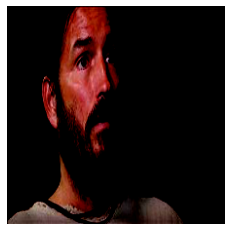

In [ ]:
final_pd_mask = np.resize(pd_mask, (image_height, image_width))
final_img = np.resize(sample_img, (image_height, image_width, 3))
plt.axis("off")
plt.imshow(final_img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


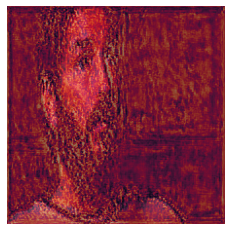

In [ ]:
# Mask on image

fig = plt.figure()
plt.axis("off")
img_1 = plt.imshow(final_img)
img_2 = plt.imshow(final_pd_mask, alpha = 0.6)
plt.show()

## **4. Use the “Prediction image” as an input to your designed model and display the output of the image.**

(500, 500, 3)


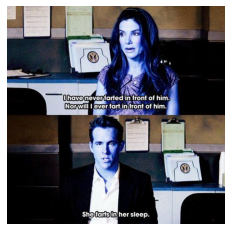

In [ ]:
# Testing the model on the test image 

test_img = cv2.imread(project_path + "Part 1Test Data - Prediction Image.jpeg")
print(test_img.shape)
plt.axis("off")
plt.imshow(test_img)
plt.show()

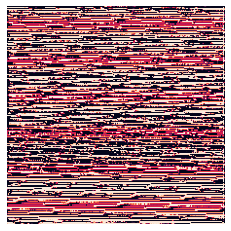

In [ ]:
# Mask for the test image

test_img = np.resize(test_img, (1, image_height, image_width, 3))
pd_mask = model.predict(x = test_img)
pd_mask = np.resize(pd_mask, (image_height, image_width))
plt.axis("off")
plt.imshow(pd_mask)
plt.show()

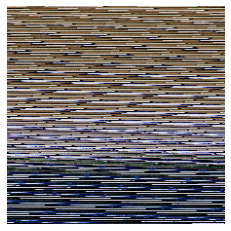

In [ ]:
final_pd_mask = np.resize(pd_mask, (image_height, image_width))
final_img = np.resize(test_img, (image_height, image_width, 3))
plt.axis("off")
plt.imshow(final_img)
plt.show()

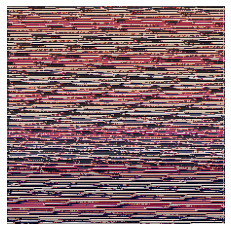

In [ ]:
# Mask imposed on the image

fig = plt.figure()
img_1 = plt.imshow(final_img)
img_2 = plt.imshow(final_pd_mask, alpha = 0.6)
plt.axis("off")
plt.show()

# **II]. PART TWO**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Set the appropriate path for the Project Path
project_path = "/content/drive/MyDrive/My Files/AIML Workbooks/"

In [ ]:
import os                   # Importing os library
import pandas as pd         # To read the data set
import numpy as np          # Importing numpy library
import seaborn as sns       # For data visualization
import matplotlib.pyplot as plt      # Necessary library for plotting graphs
from glob import glob       # Importing necessary library
%matplotlib inline
sns.set(color_codes = True)

from sklearn import metrics          # Importing metrics
from sklearn.model_selection import train_test_split       # Splitting data into train and test set
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, roc_auc_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler           # Importing to standardize the data
from sklearn.impute import SimpleImputer                   # Importing to fill in zero values in the data
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import PolynomialFeatures       # Importing polynomial features library
from sklearn.decomposition import PCA           # Importing to run pca analysis on data
from sklearn import svm              # Importing necessary library for model building
from sklearn.ensemble import RandomForestClassifier        # Importing necessary library for model building
from sklearn.neighbors import KNeighborsClassifier         # Importing necessary library for model building  
from sklearn import preprocessing               # Importing preprocessing library 

from sklearn.model_selection import KFold, cross_val_score           # Importing kfold for cross validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV           # Importing for hypertuning model
from sklearn.cluster import KMeans              # For KMeans cluster model building
from scipy.stats import zscore       # Import zscore library
from scipy.spatial.distance import cdist        # Importing cdist functionality for elbow graph
import tensorflow           # Importing tensorflow library
from tensorflow.keras.models import Sequential, Model               # Importing tensorflow library
from tensorflow.keras.utils import to_categorical          # Importing tensorflow library
from tensorflow.keras import optimizers                    # Importing optimizers
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, MaxPooling2D, Conv2D, Flatten, ZeroPadding2D, UpSampling2D, Reshape, SpatialDropout2D, Concatenate      # Importing necessary libraries 
from tensorflow.keras.applications.mobilenet import preprocess_input           # Importing for model building
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau            # Importing for model building 
from tensorflow.keras.applications.mobilenet import MobileNet       # Importing for model building 
from tensorflow.keras.losses import binary_crossentropy             # Importing for model building
from tensorflow.keras.backend import log, epsilon          # Importing necessary library for model building 
from keras.utils import np_utils     # Importing necessary library
from sklearn import svm              # Importing necessary library for model building
from sklearn.svm import SVC          # Import svc library for model building

from skimage.color import rgb2gray              # Loading color library
from sklearn.preprocessing import OneHotEncoder            # Library for one hot encoding
from sklearn.metrics import confusion_matrix               # Loading necessary library
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array            # Loading image generator 
from keras.preprocessing import image           # Importing necessary image library
from tensorflow import keras         # Loading keras libaray 
from tensorflow.keras.optimizers import Adam, SGD          # Importing optimizer library
import cv2                  # Importing necessary library
from PIL import ImageFile            # Importing image library
from tqdm import tqdm                # Importing necessary library
import time                 # Importing time library
from mpl_toolkits.axes_grid1 import ImageGrid              # Importing necessary image library
from PIL import Image       # Importing image library
import tensorflow as tf     # Importing library

In [ ]:
face_cascade = cv2.CascadeClassifier(project_path + 'haarcascade_frontalface_default.xml')

In [ ]:
# Set the appropriate path for the Dataset
dataset2_path = "Part 2 - training images.zip"

# Extracting the "Part 2 - training images.zip" to the present working directory
from zipfile import ZipFile
with ZipFile(project_path + dataset2_path, 'r') as faces_annot:
  faces_annot.extractall()

In [ ]:
face_train_images = []

for image_path in glob(os.path.join('./training_images', '*.jpg')):
  image = cv2.imread(image_path, cv2.IMREAD_COLOR)
  if image is None: # ignore if any file contains any missing value
      missing += 1
      continue
  face_train_images.append(image)

In [ ]:
# Number of images in training set
print("Number of images in training set:", len(face_train_images))

Number of images in training set: 1091


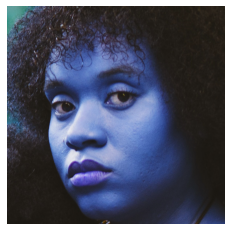

In [ ]:
# Print the sample Image 10
img = cv2.imread('training_images/real_00010.jpg', cv2.IMREAD_COLOR)
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
face_train_images = []

# Write a function to print the Face annotation
def face_annot_det(image_file):
  global face_train_images
  print(image_file)
  # Read the image from the folder
  image = cv2.imread(image_file, cv2.IMREAD_COLOR)
  if image is None: # ignore if any file contains any missing value
      missing += 1
      exit()
  face_train_images.append(image)

  # perform face detection
  faces = face_cascade.detectMultiScale(image, 1.3, 5)
  print("Image_name: ", image_file)
  print("Total_faces: ", faces.shape[0])
  # Get the coordinates of bounding box for each detected face
  for face in faces:
   # Print the coordinates of the face in a dataframe
    print(f'x: {face[0]}  y: {face[1]}   w: {face[2]}    h: {face[3]}')

In [ ]:

for image_path in glob(os.path.join('./training_images', '*.jpg')):
  face_annot_det(image_path)
  


./training_images/real_00548.jpg
Image_name:  ./training_images/real_00548.jpg
Total_faces:  1
x: 18  y: 93   w: 430    h: 430
./training_images/real_00862.jpg
Image_name:  ./training_images/real_00862.jpg
Total_faces:  1
x: 18  y: 93   w: 430    h: 430
./training_images/real_00155.jpg
Image_name:  ./training_images/real_00155.jpg
Total_faces:  1
x: 18  y: 93   w: 430    h: 430
./training_images/real_00520.jpg
Image_name:  ./training_images/real_00520.jpg
Total_faces:  1
x: 18  y: 93   w: 430    h: 430
./training_images/real_00944.jpg
Image_name:  ./training_images/real_00944.jpg
Total_faces:  1
x: 18  y: 93   w: 430    h: 430
./training_images/real_00727.jpg
Image_name:  ./training_images/real_00727.jpg
Total_faces:  1
x: 18  y: 93   w: 430    h: 430
./training_images/real_00118.jpg
Image_name:  ./training_images/real_00118.jpg
Total_faces:  1
x: 18  y: 93   w: 430    h: 430
./training_images/real_00207.jpg
Image_name:  ./training_images/real_00207.jpg
Total_faces:  1
x: 18  y: 93   w

In [ ]:
# print bounding box for each detected face
for face in faces:
	# extract
	x, y, width, height = face
	x2, y2 = x + width, y + height
	# draw a rectangle over the pixels
	rectangle(img, (x, y), (x2, y2), (255,255,255), 1)
# show the image
plt.axis("off")
plt.imshow(img)
# keep the window open until we press a key
cv2.waitKey(0)
# close the window
cv2.destroyAllWindows()

NameError: ignored

In [ ]:
faces = face_cascade.detectMultiScale(img, 1.3, 5)
#print(face.shape[0])
face.shape
#for face in faces:
 # print(face)
  

#cv2.putText(image, "Number of faces detected: " + str(faces.shape[0]), (0,image.shape[0] -10), cv2.FONT_HERSHEY_TRIPLEX, 0.5,  (0,0,0), 1)
 


(4,)

In [ ]:
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
cv2.imshow('img',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

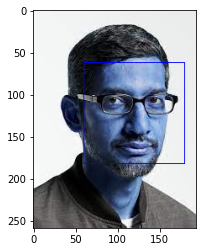

In [ ]:
# plot photo with detected faces using opencv cascade classifier
from cv2 import imread
import matplotlib.pyplot as plt
from cv2 import waitKey
from cv2 import destroyAllWindows
from cv2 import CascadeClassifier
from cv2 import rectangle
# load the photograph
pixels = imread('download.jpg')
# load the pre-trained model
classifier = CascadeClassifier('haarcascade_frontalface_default.xml')
# perform face detection
bboxes = classifier.detectMultiScale(pixels)
# print bounding box for each detected face
for box in bboxes:
	# extract
	x, y, width, height = box
	x2, y2 = x + width, y + height
	# draw a rectangle over the pixels
	rectangle(pixels, (x, y), (x2, y2), (0,0,255), 1)
# show the image
plt.imshow(pixels)
# keep the window open until we press a key
waitKey(0)
# close the window
destroyAllWindows()

# **III]. PART THREE**



## **1. Load the dataset and create the metadata.**

In [ ]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.4.1'

In [ ]:
import os                   # Importing os library
import pandas as pd         # To read the data set
import numpy as np          # Importing numpy library
import seaborn as sns       # For data visualization
import matplotlib.pyplot as plt      # Necessary library for plotting graphs
from glob import glob       # Importing necessary library
%matplotlib inline
sns.set(color_codes = True)

from sklearn import metrics          # Importing metrics
from sklearn.model_selection import train_test_split       # Splitting data into train and test set
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, roc_auc_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler           # Importing to standardize the data
from sklearn.impute import SimpleImputer                   # Importing to fill in zero values in the data
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import PolynomialFeatures       # Importing polynomial features library
from sklearn.decomposition import PCA           # Importing to run pca analysis on data
from sklearn import svm              # Importing necessary library for model building
from sklearn.ensemble import RandomForestClassifier        # Importing necessary library for model building
from sklearn.neighbors import KNeighborsClassifier         # Importing necessary library for model building  
from sklearn import preprocessing               # Importing preprocessing library 

from sklearn.model_selection import KFold, cross_val_score           # Importing kfold for cross validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV           # Importing for hypertuning model
from sklearn.cluster import KMeans              # For KMeans cluster model building
from scipy.stats import zscore       # Import zscore library
from scipy.spatial.distance import cdist        # Importing cdist functionality for elbow graph
import tensorflow           # Importing tensorflow library
from tensorflow.keras.models import Sequential, Model               # Importing tensorflow library
from tensorflow.keras.utils import to_categorical          # Importing tensorflow library
from tensorflow.keras import optimizers                    # Importing optimizers
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, MaxPooling2D, Conv2D, Flatten, ZeroPadding2D, UpSampling2D, Reshape, SpatialDropout2D, Concatenate, Convolution2D      # Importing necessary libraries 
from tensorflow.keras.applications.mobilenet import preprocess_input           # Importing for model building
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau            # Importing for model building 
from tensorflow.keras.applications.mobilenet import MobileNet       # Importing for model building 
from tensorflow.keras.losses import binary_crossentropy             # Importing for model building
from tensorflow.keras.backend import log, epsilon          # Importing necessary library for model building 
from keras.utils import np_utils     # Importing necessary library
from sklearn import svm              # Importing necessary library for model building
from sklearn.svm import SVC          # Import svc library for model building

from skimage.color import rgb2gray              # Loading color library
from sklearn.preprocessing import OneHotEncoder            # Library for one hot encoding
from sklearn.metrics import confusion_matrix               # Loading necessary library
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array            # Loading image generator 
from keras.preprocessing import image           # Importing necessary image library
from tensorflow import keras         # Loading keras libaray 
from tensorflow.keras.optimizers import Adam, SGD          # Importing optimizer library
import cv2                  # Importing necessary library
from PIL import ImageFile            # Importing image library
from tqdm import tqdm                # Importing necessary library
import time                 # Importing time library
from mpl_toolkits.axes_grid1 import ImageGrid              # Importing necessary image library
from PIL import Image       # Importing image library
import tensorflow as tf     # Importing library

In [ ]:
project_path  = '/content/drive/MyDrive/My Files/AIML Workbooks/'

In [ ]:
# File path

data_path = "Part 3 - Aligned Face Dataset from Pinterest.zip"

In [ ]:
# Extracting from zip file

from zipfile import ZipFile
with ZipFile(project_path + data_path, 'r') as face:
  face.extractall()

## **2. Check some samples of metadata.**

In [ ]:
# Define a function to load the images from the extracted folder and map each image with person id

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

In [ ]:
# Loading image from metadata

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::1]

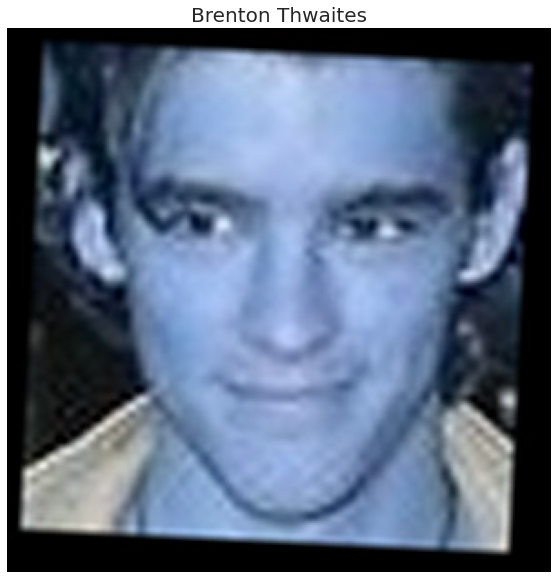

In [ ]:
# Load sample image using the function "load_image"

n = np.random.randint(1, len(metadata))
image = load_image(metadata[n].image_path())
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)

plt.axis("off")
plt.imshow(image)
plt.show()

In [ ]:
# Loading image from metadata

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::1]

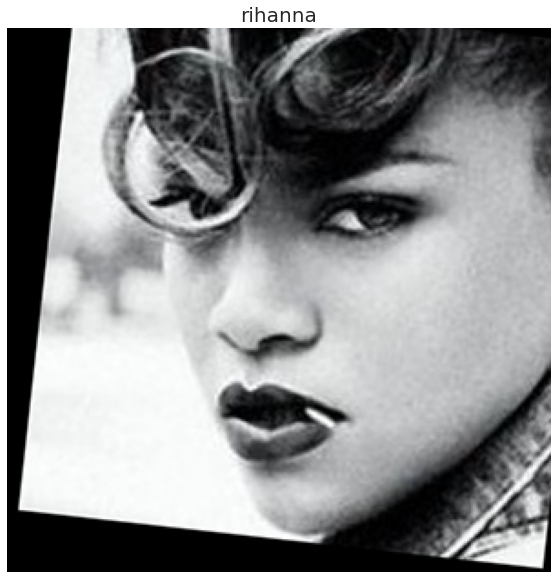

In [ ]:
# Load sample image using the function "load_image"

n = np.random.randint(1, len(metadata))
image = load_image(metadata[n].image_path())
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)

plt.axis("off")
plt.imshow(image)
plt.show()

## **3. Load the pre-trained model and weights.**

In [ ]:
# Use predefined model for VGG 

def vgg_mod():

    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [ ]:
# Loading the above defined model 

mod = vgg_mod()
mod.load_weights(project_path + 'Part 3 - vgg_face_weights.h5')
print(mod.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

In [ ]:
vgg_face = Model(inputs = mod.layers[0].input, outputs = mod.layers[-2].output)

## **4. Generate Embedding vectors for each face in the dataset.**

In [ ]:
# Embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0, 1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face model and print the shape
# If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

embedding_vector = vgg_face.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


In [ ]:
# Build distance metrics for identifying the distance between two given images.

from tqdm.notebook import tqdm

embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

## **5. Build distance metrics for identifying the distance between two given images.**

In [ ]:
def distance(embed1, embed2):
    return np.sum(np.square(embed1 - embed2))

Considering the distance metric as "Squared L2 distance"
Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2


In [ ]:
# Visualizing the images & their distances 

def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.axis("off")
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.axis("off")
    plt.imshow(load_image(metadata[idx2].image_path()))

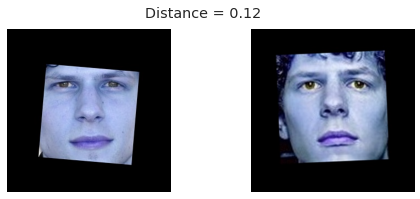

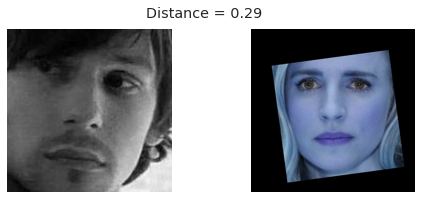

In [ ]:
show_pair(50, 51)
show_pair(70, 170)

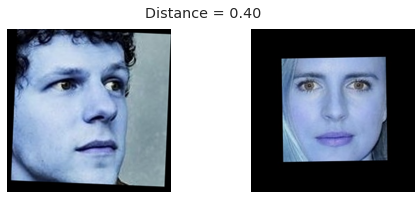

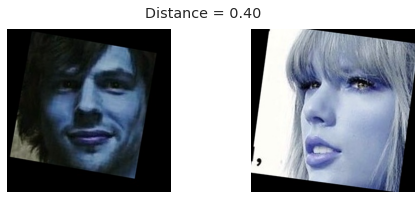

In [ ]:
show_pair(80, 115)
show_pair(90, 240)

In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
x_train = np.array(embeddings)[train_idx]
x_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

In [ ]:
# Encoding the labels

en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

In [ ]:
# Standarizing the features

sc = StandardScaler()
x_train_sc = sc.fit_transform(x_train)
x_test_sc = sc.transform(x_test)

## **6. Use PCA for dimensionality reduction.**

In [ ]:
# Covariance matrix
cov_mat = np.cov(x_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.60497834  19.47013665  23.29490742 ...  99.99999984  99.99999999
 100.        ]


In [ ]:
# Get index where cumulative variance explained is > threshold

threshold = 95
res = list(filter(lambda i: i > threshold, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {threshold}: {str(index)}')

Index of element just greater than 95: 344


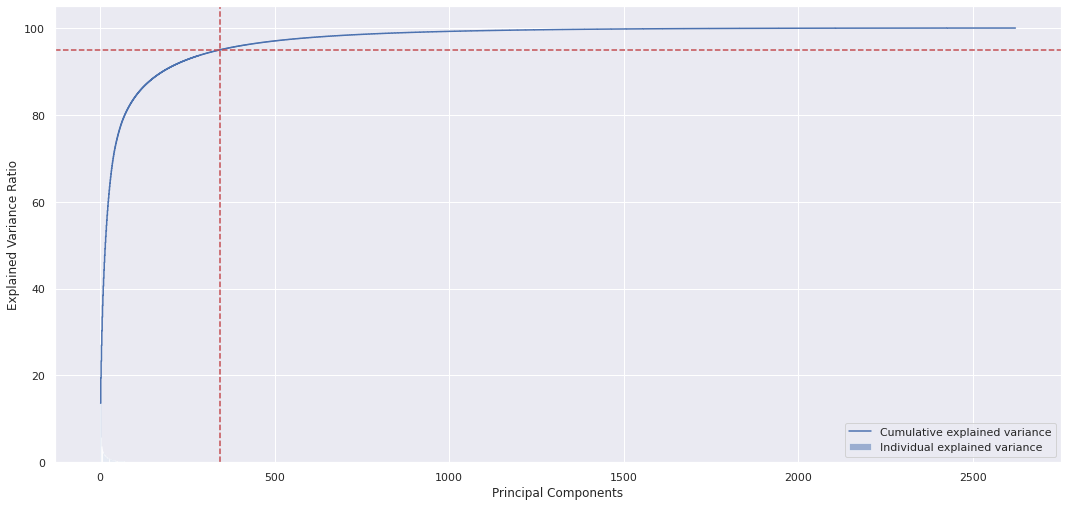

In [ ]:
# Visualizing individual & cummulative variance 

plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = threshold, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [ ]:
# Dimenson reduction 

dim = PCA(n_components = index, random_state = 42, svd_solver = 'full', whiten = True)
dim.fit(x_train_sc)

x_train_pca = dim.transform(x_train_sc)
x_test_pca = dim.transform(x_test_sc)
display(x_train_pca.shape, x_test_pca.shape)

(9573, 344)

(1197, 344)

## **7. Build an SVM classifier to map each image to its right person.**

In [ ]:
# Building svm model

svm_pca = SVC(C = 1, gamma = 0.0025, kernel = 'rbf', class_weight = 'balanced', random_state = 42)
svm_pca.fit(x_train_pca, y_train)

print('SVC accuracy for train set: {0:.3f}'.format(svm_pca.score(x_train_pca, y_train)))

SVC accuracy for train set: 0.998


In [ ]:
# Predicting 
y_pred = svm_pca.predict(x_test_pca)

print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))     # Accuracy Score

Accuracy Score: 0.961


In [ ]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      0.92      0.96        13
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         8
          Amaury Nolasco       1.00      1.00      1.00         9
        Amber Heard Face       1.00      0.71      0.83         7
               Anna Gunn       0.92      0.86      0.89        14
           Anne Hathaway       1.00      1.00      1.00        13
     Barbara Palvin Face       0.90      1.00      0.95         9
      Bellamy Blake Face       1.00      0.93      0.96        14
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       0.75      1.00      

In [ ]:
def sample_img_plot(sample_idx):

  # Load image for sample_idx from test data
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())

  # Get actual name
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()

  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)

  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face.predict(np.expand_dims(sample_img, axis = 0))[0]

  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))

  # Predict
  sample_pred = svm_pca.predict(dim.transform(embedding_scaled))

  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

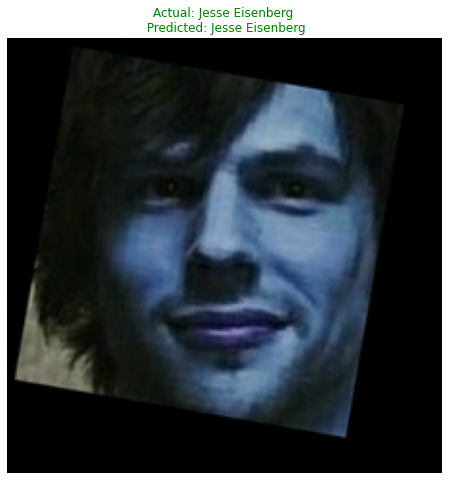

In [ ]:
# Plot for 10th image in test data

sample_img, actual_name, pred_name = sample_img_plot(10)
fig = plt.figure(figsize = (15, 8))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"Actual: {actual_name} \n Predicted: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

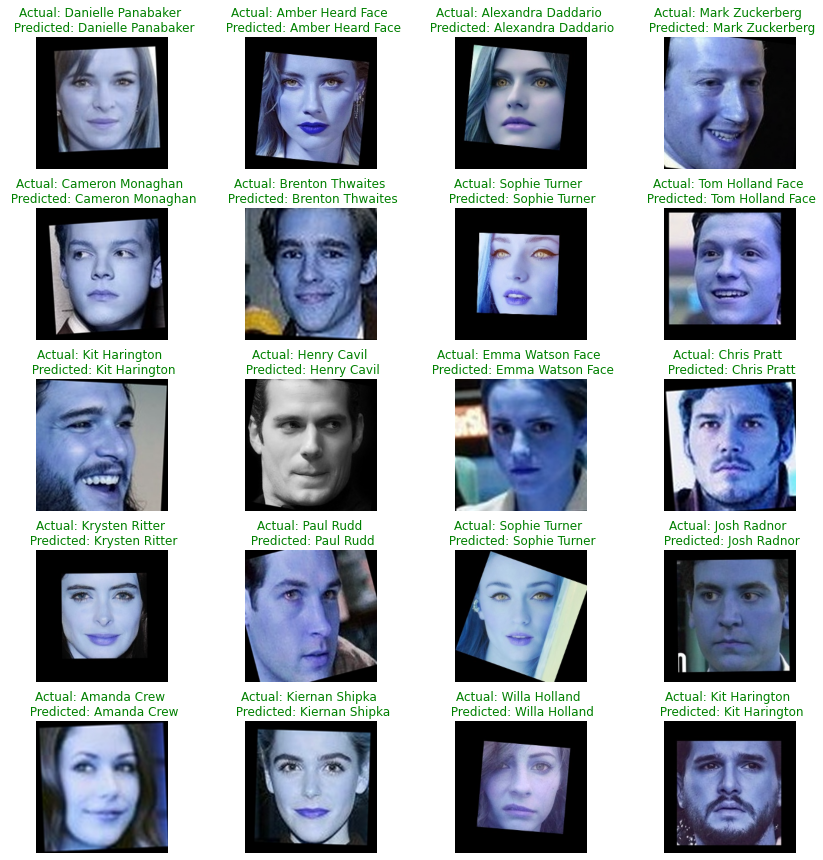

In [ ]:
import matplotlib.gridspec as gridspec
import random 

# Random 20 sample images from test data

plt.figure(figsize = (15, 15))
gs1 = gridspec.GridSpec(5, 4)
gs1.update(wspace = 0, hspace = 0.3) 

for i in range(20):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    sample_img, actual_name, pred_name = sample_img_plot(random.randint(1, 1197))
  
    plt.axis('off')
    plt.imshow(sample_img)
  
    plt.title(f"Actual: {actual_name} \n Predicted: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

## **Observation :**

Task here was to recognize (aligned) faces from a dataset containing 10k+ images for 100 people using a pre-trained model on Face Recognition.

- VGG model with pre-trained weights was used to generate embeddings for each images in the dataset.
- Since, there were 2,622 features for each image, PCA was used for dimension reduction after standardizing the features.
- Using SVC we predicted the labels for test dataset with an accuracy of more than 96%.
- Compared predicted and Actual labels for a given sample image as well as for 20 random images from test dataset.
- Distance between two pair of images was calculated.
- Cumulative explained variance of 95%, 347 PCA components were used.

# **IV]. PART FOUR // VIDEO FILE**



In [ ]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set the appropriate path for the Project

path = "/content/drive/MyDrive/My Files/AIML Workbooks/"

In [ ]:
%tensorflow_version 1.4.x
import tensorflow
tensorflow.__version__

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4.x`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


'1.15.2'

In [ ]:
import os                   # Importing os library
import pandas as pd         # To read the data set
import numpy as np          # Importing numpy library
import seaborn as sns       # For data visualization
import matplotlib.pyplot as plt      # Necessary library for plotting graphs
from glob import glob       # Importing necessary library
%matplotlib inline
sns.set(color_codes = True)

from sklearn import metrics          # Importing metrics
from sklearn.model_selection import train_test_split       # Splitting data into train and test set
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, roc_auc_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler           # Importing to standardize the data
from sklearn.impute import SimpleImputer                   # Importing to fill in zero values in the data
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import PolynomialFeatures       # Importing polynomial features library
from sklearn.decomposition import PCA           # Importing to run pca analysis on data
from sklearn import svm              # Importing necessary library for model building
from sklearn.ensemble import RandomForestClassifier        # Importing necessary library for model building
from sklearn.neighbors import KNeighborsClassifier         # Importing necessary library for model building  
from sklearn import preprocessing               # Importing preprocessing library 

from sklearn.model_selection import KFold, cross_val_score           # Importing kfold for cross validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV           # Importing for hypertuning model
from sklearn.cluster import KMeans              # For KMeans cluster model building
from scipy.stats import zscore       # Import zscore library
from scipy.spatial.distance import cdist        # Importing cdist functionality for elbow graph
import tensorflow           # Importing tensorflow library
from tensorflow.keras.models import Sequential, Model             # Importing tensorflow library
from tensorflow.keras.utils import to_categorical          # Importing tensorflow library
from tensorflow.keras import optimizers                    # Importing optimizers
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, MaxPooling2D, Conv2D, Flatten      # Importing necessary libraries 
from keras.utils import np_utils     # Importing necessary library
from sklearn import svm              # Importing necessary library for model building
from sklearn.svm import SVC          # Import svc library for model building

from skimage.color import rgb2gray              # Loading color library
from sklearn.preprocessing import OneHotEncoder            # Library for one hot encoding
from sklearn.metrics import confusion_matrix               # Loading necessary library
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array            # Loading image generator 
from keras.preprocessing import image           # Importing necessary image library
from tensorflow import keras         # Loading keras libaray 
from tensorflow.keras.optimizers import Adam, SGD          # Importing optimizer library
import cv2                  # Importing necessary library
from PIL import ImageFile            # Importing image library
from tqdm import tqdm                # Importing necessary library
import time                 # Importing time library
from mpl_toolkits.axes_grid1 import ImageGrid              # Importing necessary image library
from PIL import Image       # Importing image library

In [ ]:
import os, sys
import random
import math
import skimage.io
import matplotlib
from matplotlib.patches import Polygon 

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 30.91 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [ ]:
os.chdir("/content/Mask_RCNN")
sys.path.append("/content/Mask_RCNN")
VIDEO_STREAM = "/content/drive/MyDrive/My Files/AIML Workbooks/Part 4 - Video/video1.mp4"
VIDEO_STREAM_OUT = "/content/drive/MyDrive/My Files/AIML Workbooks/Part 4 - Video/Result/video1.mp4"  

In [ ]:
# Root directory of the project

ROOT_DIR = os.path.abspath(".")

In [ ]:
# Import Mask RCNN

sys.path.append(ROOT_DIR)     # To find local version of the library

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config

sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))       # To find local version
import coco 

In [ ]:
# Directory to save logs and trained model

MODEL_DIR = os.path.join(ROOT_DIR, "logs")
  
# Local path to trained weights file

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
  
# Directory of images to run detection on

IMAGE_DIR = os.path.join(ROOT_DIR, "images")
  
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1 

In [ ]:
def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = visualize.random_colors(n_instances)
  
    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]
  
    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue
  
        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]
  
        image = visualize.apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(
            image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )
  
    return image 

In [ ]:
config = InferenceConfig()
config.display() 


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# Create model object in inference mode.

model = modellib.MaskRCNN(mode = 'inference', model_dir = MODEL_DIR, config = config)

# Load weights trained on MS-COCO

model.load_weights(COCO_MODEL_PATH, by_name=True)
  
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of

class_names = ['person', 'bus', 'car', 'motorcycle']

In [ ]:
# Initialize the video stream and pointer to output video file

vs = cv2.VideoCapture(VIDEO_STREAM)
writer = None
vs.set(cv2.CAP_PROP_POS_FRAMES, 5)

True

In [ ]:
i = 0
while i < 20:
  # read the next frame from the file
  (grabbed, frame) = vs.read()
  i += 1
   
  # If the frame was not grabbed, then we have reached the end of the stream

  if not grabbed:
    print ("Not grabbed.")
    break;
    
  # Run detection
  results = model.detect([frame], verbose=1)
  
  # Visualize results
  r = results[0]
  masked_frame = display_instances(frame, r['rois'], r['masks'], r['class_ids'],
                            class_names, r['scores'])
    
  # Check if the video writer is None
  if writer is None:
    # Initialize our video writer
    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    writer = cv2.VideoWriter(VIDEO_STREAM_OUT, fourcc, 30,
      (masked_frame.shape[1], masked_frame.shape[0]), True)
   
  # Write the output frame to disk
  writer.write(masked_frame)
    
# Release the file pointers
print("[INFO] cleaning up...")
writer.release()

Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
NO INSTANCES TO DISPLAY
Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
NO INSTANCES TO DISPLAY
Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1